In [1]:
%pylab inline
%config InlineBackend.figure_format = 'retina'

Populating the interactive namespace from numpy and matplotlib


In [2]:
import astropy.cosmology as cosmo
from astropy.cosmology import Planck15
import astropy.units as u
import h5py
import lalsimulation as ls
import pandas as pd
import seaborn as sns

import sys

d = 'vt'
try:
    sys.path.index(d)
except ValueError:
    sys.path.append(d)
    
import vt

sns.set_context('notebook')
sns.set_style('ticks')
sns.set_palette('colorblind')

Let's look at our sensitivity to a 30-30 merger at design sensitivity:

In [3]:
vt_3030 = vt.vt_from_mass(30, 30, 8, 1.0, psd_fn=ls.SimNoisePSDaLIGOaLIGODesignSensitivityT1800044)
dC_range = cbrt(vt_3030/(4/3*pi))
print('Sensitive volume for 30-30 inspirals is {:.2f} Gpc^3, or a range of {:.2f} Gpc (comoving distance)'.format(vt_3030, dC_range))

Sensitive volume for 30-30 inspirals is 1.90 Gpc^3, or a range of 0.77 Gpc (comoving distance)


In [4]:
Tobs = 5 # Year
Ndet = 5000 # per Gpc^3 per year
n0 = Ndet/(vt_3030*Tobs)
print('Effective merger rate is {:.0f} Gpc^-3 yr^-1'.format(n0))

Effective merger rate is 527 Gpc^-3 yr^-1


In [5]:
r_bao = 100/0.7/1000 # Gpc
w_bao = 15/0.7/1000 # Gpc
A_bao = 0.01

def xi_bao(r):
    return A_bao*exp(-0.5*square(r-r_bao)/(w_bao*w_bao))

exp_scale = 5/1000 # Gpc

def xi_exp(r):
    return exp(-r/exp_scale)

print('BAO correlation length is {:.3f} Gpc'.format(r_bao))
print('Width of BAO Gaussian is {:.3f} Gpc'.format(w_bao))

BAO correlation length is 0.143 Gpc
Width of BAO Gaussian is 0.021 Gpc


In [6]:
def bao_covariance(xs):
    rvec = xs[newaxis,:,:] - xs[:,newaxis,:]
    rs = np.sqrt(np.sum(rvec*rvec, axis=2))
    xi_rs = xi_bao(rs) + xi_exp(rs)
    
    return xi_rs

Total volume in BAO = 0.00014 Gpc^3 = 143992.7 Mpc^3


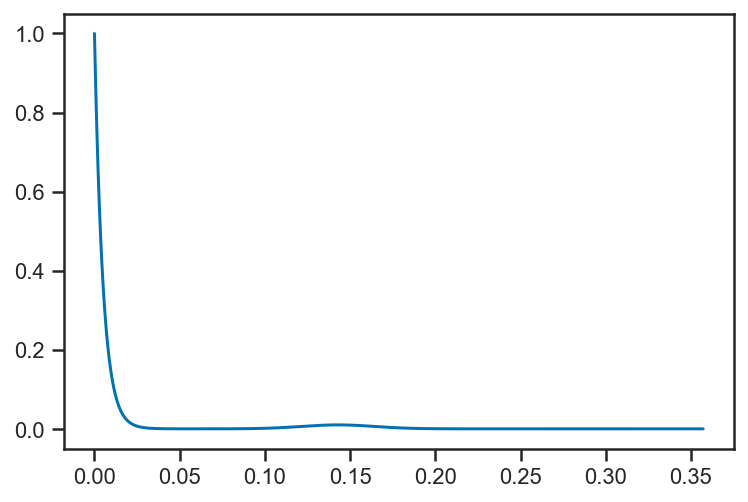

In [7]:
rs = linspace(0, r_bao + 10*w_bao, 1000)
xi_rs = xi_bao(rs) + xi_exp(rs)
plot(rs, xi_rs)
W_bao = trapz(4*pi*rs*rs*xi_rs, rs)
print('Total volume in BAO = {:.5f} Gpc^3 = {:.1f} Mpc^3'.format(W_bao, W_bao*1e9))

Here is the power w/i an 8 Mpc volume:

In [8]:
rs = linspace(0, 8/1000, 100)
P8 = trapz((xi_bao(rs)+xi_exp(rs))*4*pi*rs*rs, rs)

In [9]:
print('Power on 8 Mpc scales is {:g} Gpc^3'.format(P8))
sigma_8 = 1.0 # Mpc^3
A2 = sigma_8*sigma_8/P8/1e9
print('So fractional amplitude variance parameter is {:g}'.format(A2))

Power on 8 Mpc scales is 6.80604e-07 Gpc^3
So fractional amplitude variance parameter is 0.00146928


Here we reproducably draw from this GP (totally real space---don't want to mess around with FT amplitudes).

In [10]:
rstate = np.random.get_state()
try:
    np.random.seed(1363279349)

    N = 20000
    XYZ = 2*dC_range*np.random.rand(N, 3) - dC_range
    C = A2*bao_covariance(XYZ)
    L = np.linalg.cholesky(C)
    log_N = log(n0) + np.dot(L,np.random.randn(N))
    log_random = np.max(log_N) + log(np.random.rand(N))
    sel = log_random < log_N

    pts_all = XYZ[sel,:]
    
    r2s = np.sum(pts_all*pts_all, axis=1)
    
    sel = r2s < dC_range*dC_range

    pts_all = pts_all[sel,:]
    
    N_merg = 5000
    pts = pts_all[:N_merg, :]
finally:
    np.random.set_state(rstate)

Let's plot the distribution of the rates at the random points:

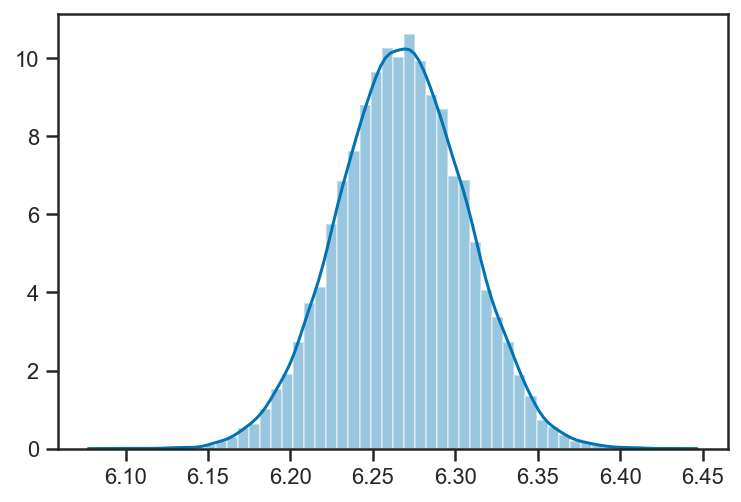

In [11]:
sns.distplot(log_N)

We make our points into a pandas data frame so that Seaborn is happy plotting it:

In [12]:
pts = pd.DataFrame(data=pts, columns=['x', 'y', 'z'])

Her's what it looks like---pretty uniform, but to my eye there seem to be characteristic scaled gaps that are of order 100 Mpc.

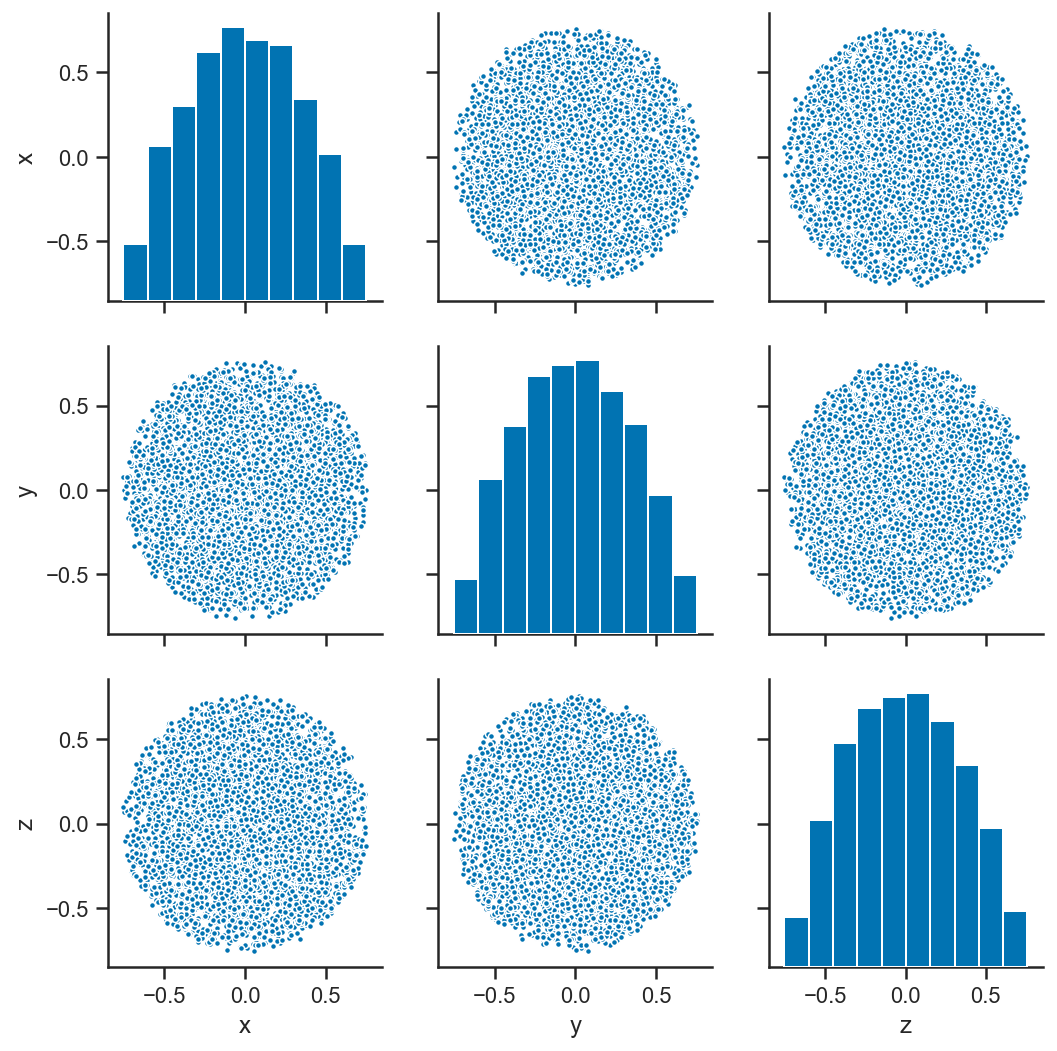

In [13]:
sns.pairplot(pts, markers='.')

In [14]:
with h5py.File('comoving-positions.h5', 'w') as out:
    out.create_dataset('pos', data=pts, compression='gzip', shuffle=True)

In [15]:
def normalize(v):
    return v / np.sqrt(np.sum(v*v))

def draw_observation(xyz):
    x, y, z = xyz
    d = np.sqrt(np.sum(xyz*xyz))
    
    rhat = normalize(xyz)
    
    v = np.random.randn(3)
    vp = v - np.dot(rhat, v)*rhat
    xhat = normalize(vp)
    yhat = np.cross(xhat, rhat)
    
    T_xyz_to_rxy = np.row_stack((rhat, xhat, yhat))
    
    sigma_r = exp(log(0.15) + 0.5*np.random.randn())*d
    sigma_x = exp(log(6*pi/180) + 0.5*np.random.randn())
    sigma_y = exp(log(10*pi/180) + 0.5*np.random.randn())
    
    Sigma = np.dot(T_xyz_to_rxy.T, np.dot(np.diag((sigma_r*sigma_r, sigma_x*sigma_x, sigma_y*sigma_y)), T_xyz_to_rxy))
    
    xyz_obs = xyz + np.dot(np.linalg.cholesky(Sigma), randn(3))
    
    return (xyz_obs, Sigma)

In [16]:
rstate = np.random.get_state()
try:
    np.random.seed(32118314)

    pts_obs = pd.DataFrame(columns=['x', 'y', 'z'])
    Sigma_obs = []
    for i, pt in pts.iterrows():
        pt_obs, Sigma = draw_observation(pt)
        pts_obs = pts_obs.append(pt_obs)
        Sigma_obs.append(Sigma)
    Sigma_obs = array(Sigma_obs)
    
finally:
    np.random.set_state(rstate)

In [17]:
with h5py.File('comoving-observations.h5', 'w') as out:
    out.create_dataset('pos', data=pts_obs, compression='gzip', shuffle=True)
    out.create_dataset('Sigma_pos', data=Sigma_obs, compression='gzip', shuffle=True)

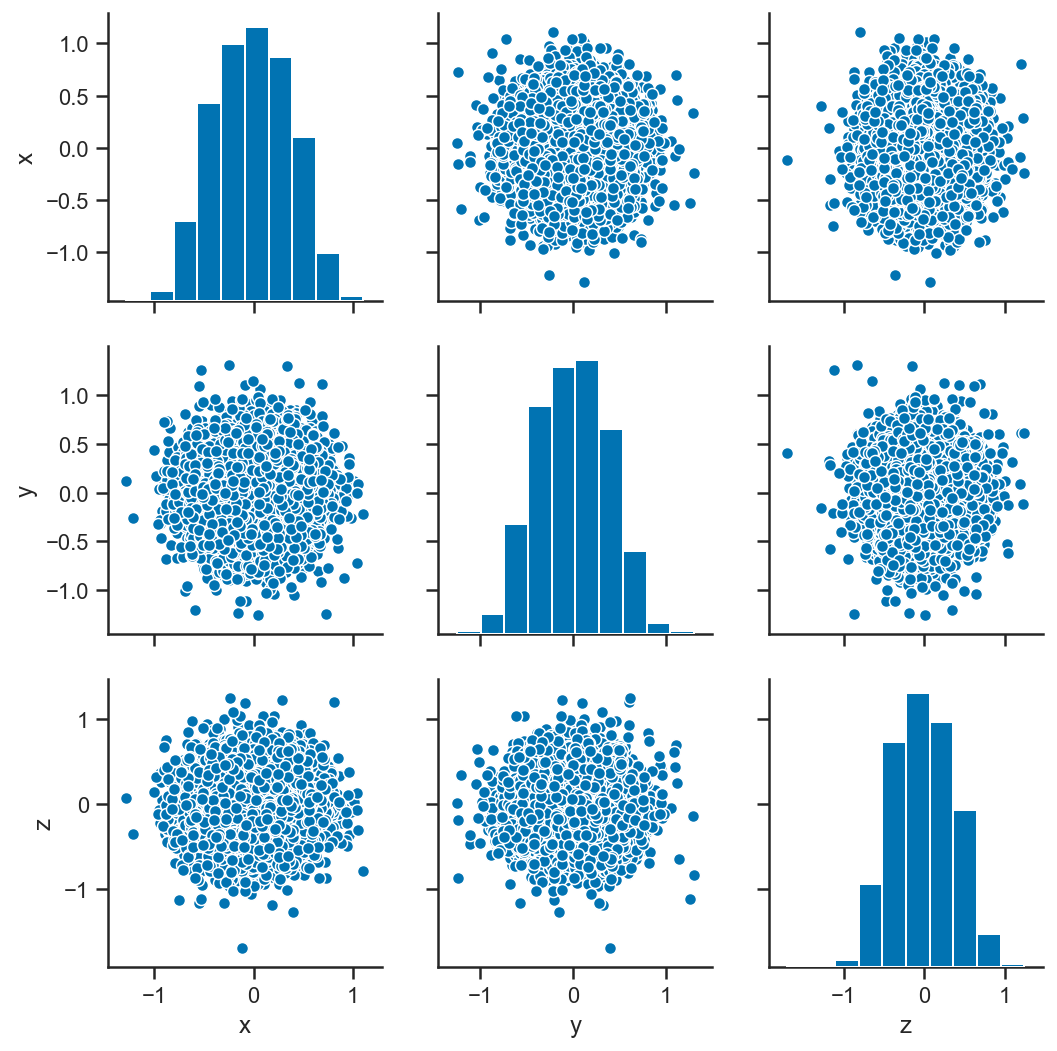

In [18]:
sns.pairplot(pts_obs)